ipykernel


jupyter 


https://www.kaggle.com/code/taraprole/roadsignclassifier
    
to use resnet: https://www.pluralsight.com/guides/introduction-to-resnet    

to download datasets: https://github.com/surmenok/GTSRB/blob/master/german-traffic-signs.ipynb

https://datasets.activeloop.ai/docs/ml/datasets/gtsrb-dataset/

In [3]:
import deeplake


In [5]:
import torch
import torchvision
from torchvision import transforms,models
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn

import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [6]:
## clear memory
torch.cuda.empty_cache()

transforms

In [7]:
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

hyper parameters

In [8]:
BATCH_SIZE = 16
learning_rate = 0.001
EPOCHS = 7
numClasses = 43

to read from train csv : https://www.kaggle.com/code/harshit1900/german-traffic-signs-beginners/notebook

In [9]:
ds_train = deeplake.load("hub://activeloop/gtsrb-train")

hub://activeloop/gtsrb-train loaded successfully.

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtsrb-train



In [10]:
ds_train.tensors.keys()    # dict_keys(['images', 'labels'])


dict_keys(['images', 'boxes', 'labels', 'shapes', 'colors'])

In [11]:
ds_train.labels[0].numpy() # array([6], dtype=uint32)

array([18], dtype=uint32)

In [12]:
ds_test = deeplake.load("hub://activeloop/gtsrb-test")

hub://activeloop/gtsrb-test loaded successfully.

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtsrb-test



In [13]:
ds_test.tensors.keys()    # dict_keys(['images', 'labels'])


dict_keys(['images', 'boxes', 'labels', 'shapes', 'colors'])

In [14]:
ds_test.labels[0].numpy() # array([6], dtype=uint32)

array([11], dtype=uint32)

In [15]:
train_loader = ds_train.pytorch(num_workers=0, batch_size=4, transform={
                        'images': data_transforms, 'labels': None}, shuffle=True)

/home/cham_si/anaconda3/envs/lrnconcept/lib/python3.9/site-packages/deeplake/integrations/pytorch/common.py:91: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(


In [16]:
ds_train.labels.info.class_names

['pedestrian',
 'speed_limit_20km/hr',
 'speed_limit_30km⁄hr',
 'no_passing_of _vehicle_over_3.5ton',
 'crossroads',
 'priority_road_sign',
 'yield',
 'stop',
 'no_vehicles',
 'vehicle_over_3.5ton_prohibited',
 'no_entry',
 'general_caution',
 'dangerous_curve_to_left',
 'speed_limit_50km⁄hr',
 'dangerous_curve_to_right',
 'double_curve',
 'bumpy_road',
 'slippery_road',
 'narrow_road_on_right',
 'road_work',
 'traffic_sign',
 'chikdren_crossing',
 'bicycle_crossing',
 'speed_limit_60km⁄hr',
 'beware_of_ice/snow',
 'wild_animal_crossing',
 'end_of_all_speed_and_passing_limit',
 'compulsory_turn_right',
 'compulsory_turn_left',
 'straight_ahead',
 'go_straight_or_right',
 'go_straight_or_left',
 'avoid_obstacle_on_right',
 'avoid_obstacle_on_left',
 'speed_limit_70km⁄hr',
 'roundabout',
 'end_of_no_passing',
 'end_of_no_passing_by_vehicle_over_3.5ton',
 'speed_limit_80km⁄hr',
 'end_of_speed_limit_80km/hr',
 'speed_limit_100km⁄hr',
 'speed_limit_120km⁄hr',
 'no_passing']

In [17]:
len(ds_train.labels.info.class_names)

43

In [18]:
test_loader = ds_test.pytorch(num_workers=0, batch_size=4, transform={
                        'images': data_transforms, 'labels': None}, shuffle=True)

In [19]:
net = models.resnet50(pretrained=True)
net.fc = torch.nn.Linear(net.fc.in_features, len(ds_train.labels.info.class_names))
net.eval

/home/cham_si/anaconda3/envs/lrnconcept/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cham_si/anaconda3/envs/lrnconcept/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<bound method Module.eval of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ke

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [21]:
net = net.cuda() if device else net

In [22]:
    
loss_criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

training for 2 epochs

In [25]:
for epoch in range(2):
    train_loss =0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader):
        #print(i,data)
        images,labels = data['images'],data['labels']
        images, labels = images.to(device), labels.to(device)
        
        ## zero the parameter gradients # Clean existing gradients
        optimizer.zero_grad()
        
        ## forward + backward + optimize
        # Forward pass - compute outputs on input data using the model
        outputs = net(images)
        # Compute loss
        loss = loss_criterion(outputs,labels.reshape(-1))
        # Backpropagate the gradients
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Compute the total loss for the batch and add it to train_loss
        train_loss +=loss.item() * images.size(0)
        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * images.size(0)
        if i%10 == 9: ## print every 100 mini batches
            print('"Batch number:{:03d}, Epoch:{:03d}, Training: Loss: {:.4f} , Accuracy: {:.4f}'.format(i+1,epoch+1, loss.item(), acc.item()))
                # epoch + 1, i + 1, running_loss / 100


"Batch number:010, Epoch:001, Training: Loss: 0.8379 , Accuracy: 0.7500
"Batch number:020, Epoch:001, Training: Loss: 1.8231 , Accuracy: 0.7500
"Batch number:030, Epoch:001, Training: Loss: 1.5980 , Accuracy: 0.7500
"Batch number:040, Epoch:001, Training: Loss: 0.9463 , Accuracy: 0.7500
"Batch number:050, Epoch:001, Training: Loss: 0.6136 , Accuracy: 0.5000
"Batch number:060, Epoch:001, Training: Loss: 1.0740 , Accuracy: 0.5000
"Batch number:070, Epoch:001, Training: Loss: 0.5134 , Accuracy: 0.7500
"Batch number:080, Epoch:001, Training: Loss: 0.1675 , Accuracy: 1.0000
"Batch number:090, Epoch:001, Training: Loss: 0.9848 , Accuracy: 0.5000
"Batch number:100, Epoch:001, Training: Loss: 0.1927 , Accuracy: 1.0000
"Batch number:110, Epoch:001, Training: Loss: 3.1571 , Accuracy: 0.2500
"Batch number:120, Epoch:001, Training: Loss: 1.0098 , Accuracy: 0.5000
"Batch number:130, Epoch:001, Training: Loss: 0.3702 , Accuracy: 1.0000
"Batch number:140, Epoch:001, Training: Loss: 0.0363 , Accuracy:

"Batch number:1150, Epoch:001, Training: Loss: 0.8605 , Accuracy: 0.7500
"Batch number:1160, Epoch:001, Training: Loss: 0.3015 , Accuracy: 1.0000
"Batch number:1170, Epoch:001, Training: Loss: 2.6941 , Accuracy: 0.0000
"Batch number:1180, Epoch:001, Training: Loss: 0.1159 , Accuracy: 1.0000
"Batch number:1190, Epoch:001, Training: Loss: 0.3481 , Accuracy: 0.7500
"Batch number:1200, Epoch:001, Training: Loss: 0.4950 , Accuracy: 1.0000
"Batch number:1210, Epoch:001, Training: Loss: 1.6396 , Accuracy: 0.7500
"Batch number:1220, Epoch:001, Training: Loss: 0.6859 , Accuracy: 1.0000
"Batch number:1230, Epoch:001, Training: Loss: 0.0270 , Accuracy: 1.0000
"Batch number:1240, Epoch:001, Training: Loss: 0.3719 , Accuracy: 1.0000
"Batch number:1250, Epoch:001, Training: Loss: 0.0472 , Accuracy: 1.0000
"Batch number:1260, Epoch:001, Training: Loss: 0.3341 , Accuracy: 1.0000
"Batch number:1270, Epoch:001, Training: Loss: 0.4582 , Accuracy: 0.7500
"Batch number:1280, Epoch:001, Training: Loss: 0.07

"Batch number:2280, Epoch:001, Training: Loss: 0.0016 , Accuracy: 1.0000
"Batch number:2290, Epoch:001, Training: Loss: 0.0259 , Accuracy: 1.0000
"Batch number:2300, Epoch:001, Training: Loss: 0.0033 , Accuracy: 1.0000
"Batch number:2310, Epoch:001, Training: Loss: 0.0008 , Accuracy: 1.0000
"Batch number:2320, Epoch:001, Training: Loss: 0.0135 , Accuracy: 1.0000
"Batch number:2330, Epoch:001, Training: Loss: 0.0005 , Accuracy: 1.0000
"Batch number:2340, Epoch:001, Training: Loss: 0.0024 , Accuracy: 1.0000
"Batch number:2350, Epoch:001, Training: Loss: 0.0059 , Accuracy: 1.0000
"Batch number:2360, Epoch:001, Training: Loss: 0.0030 , Accuracy: 1.0000
"Batch number:2370, Epoch:001, Training: Loss: 0.0061 , Accuracy: 1.0000
"Batch number:2380, Epoch:001, Training: Loss: 0.0290 , Accuracy: 1.0000
"Batch number:2390, Epoch:001, Training: Loss: 0.0034 , Accuracy: 1.0000
"Batch number:2400, Epoch:001, Training: Loss: 0.0297 , Accuracy: 1.0000
"Batch number:2410, Epoch:001, Training: Loss: 0.00

"Batch number:3410, Epoch:001, Training: Loss: 0.0036 , Accuracy: 1.0000
"Batch number:3420, Epoch:001, Training: Loss: 0.0096 , Accuracy: 1.0000
"Batch number:3430, Epoch:001, Training: Loss: 0.0043 , Accuracy: 1.0000
"Batch number:3440, Epoch:001, Training: Loss: 0.0064 , Accuracy: 1.0000
"Batch number:3450, Epoch:001, Training: Loss: 0.0033 , Accuracy: 1.0000
"Batch number:3460, Epoch:001, Training: Loss: 0.0132 , Accuracy: 1.0000
"Batch number:3470, Epoch:001, Training: Loss: 0.0071 , Accuracy: 1.0000
"Batch number:3480, Epoch:001, Training: Loss: 0.0093 , Accuracy: 1.0000
"Batch number:3490, Epoch:001, Training: Loss: 0.0216 , Accuracy: 1.0000
"Batch number:3500, Epoch:001, Training: Loss: 0.0026 , Accuracy: 1.0000
"Batch number:3510, Epoch:001, Training: Loss: 0.0031 , Accuracy: 1.0000
"Batch number:3520, Epoch:001, Training: Loss: 0.1364 , Accuracy: 1.0000
"Batch number:3530, Epoch:001, Training: Loss: 0.0120 , Accuracy: 1.0000
"Batch number:3540, Epoch:001, Training: Loss: 0.37

"Batch number:4540, Epoch:001, Training: Loss: 0.1501 , Accuracy: 1.0000
"Batch number:4550, Epoch:001, Training: Loss: 0.3306 , Accuracy: 0.7500
"Batch number:4560, Epoch:001, Training: Loss: 0.3208 , Accuracy: 0.7500
"Batch number:4570, Epoch:001, Training: Loss: 0.0453 , Accuracy: 1.0000
"Batch number:4580, Epoch:001, Training: Loss: 0.0755 , Accuracy: 1.0000
"Batch number:4590, Epoch:001, Training: Loss: 0.4000 , Accuracy: 0.7500
"Batch number:4600, Epoch:001, Training: Loss: 0.0734 , Accuracy: 1.0000
"Batch number:4610, Epoch:001, Training: Loss: 2.9556 , Accuracy: 0.2500
"Batch number:4620, Epoch:001, Training: Loss: 0.0418 , Accuracy: 1.0000
"Batch number:4630, Epoch:001, Training: Loss: 1.0366 , Accuracy: 0.5000
"Batch number:4640, Epoch:001, Training: Loss: 0.9021 , Accuracy: 0.7500
"Batch number:4650, Epoch:001, Training: Loss: 0.0171 , Accuracy: 1.0000
"Batch number:4660, Epoch:001, Training: Loss: 0.0626 , Accuracy: 1.0000
"Batch number:4670, Epoch:001, Training: Loss: 0.05

"Batch number:5670, Epoch:001, Training: Loss: 0.0937 , Accuracy: 1.0000
"Batch number:5680, Epoch:001, Training: Loss: 0.0036 , Accuracy: 1.0000
"Batch number:5690, Epoch:001, Training: Loss: 0.0178 , Accuracy: 1.0000
"Batch number:5700, Epoch:001, Training: Loss: 0.0296 , Accuracy: 1.0000
"Batch number:5710, Epoch:001, Training: Loss: 0.0675 , Accuracy: 1.0000
"Batch number:5720, Epoch:001, Training: Loss: 0.0073 , Accuracy: 1.0000
"Batch number:5730, Epoch:001, Training: Loss: 0.0149 , Accuracy: 1.0000
"Batch number:5740, Epoch:001, Training: Loss: 0.0230 , Accuracy: 1.0000
"Batch number:5750, Epoch:001, Training: Loss: 0.7837 , Accuracy: 0.7500
"Batch number:5760, Epoch:001, Training: Loss: 0.0027 , Accuracy: 1.0000
"Batch number:5770, Epoch:001, Training: Loss: 0.0147 , Accuracy: 1.0000
"Batch number:5780, Epoch:001, Training: Loss: 0.0078 , Accuracy: 1.0000
"Batch number:5790, Epoch:001, Training: Loss: 0.0143 , Accuracy: 1.0000
"Batch number:5800, Epoch:001, Training: Loss: 1.22

"Batch number:6800, Epoch:001, Training: Loss: 0.0069 , Accuracy: 1.0000
"Batch number:6810, Epoch:001, Training: Loss: 0.0048 , Accuracy: 1.0000
"Batch number:6820, Epoch:001, Training: Loss: 0.0055 , Accuracy: 1.0000
"Batch number:6830, Epoch:001, Training: Loss: 0.0017 , Accuracy: 1.0000
"Batch number:6840, Epoch:001, Training: Loss: 0.0765 , Accuracy: 1.0000
"Batch number:6850, Epoch:001, Training: Loss: 0.0054 , Accuracy: 1.0000
"Batch number:6860, Epoch:001, Training: Loss: 0.0009 , Accuracy: 1.0000
"Batch number:6870, Epoch:001, Training: Loss: 0.0005 , Accuracy: 1.0000
"Batch number:6880, Epoch:001, Training: Loss: 0.0018 , Accuracy: 1.0000
"Batch number:6890, Epoch:001, Training: Loss: 0.0026 , Accuracy: 1.0000
"Batch number:6900, Epoch:001, Training: Loss: 0.0184 , Accuracy: 1.0000
"Batch number:6910, Epoch:001, Training: Loss: 0.0015 , Accuracy: 1.0000
"Batch number:6920, Epoch:001, Training: Loss: 0.0017 , Accuracy: 1.0000
"Batch number:6930, Epoch:001, Training: Loss: 0.00

"Batch number:7930, Epoch:001, Training: Loss: 0.0560 , Accuracy: 1.0000
"Batch number:7940, Epoch:001, Training: Loss: 0.0826 , Accuracy: 1.0000
"Batch number:7950, Epoch:001, Training: Loss: 0.0419 , Accuracy: 1.0000
"Batch number:7960, Epoch:001, Training: Loss: 0.0652 , Accuracy: 1.0000
"Batch number:7970, Epoch:001, Training: Loss: 0.2059 , Accuracy: 1.0000
"Batch number:7980, Epoch:001, Training: Loss: 0.1663 , Accuracy: 1.0000
"Batch number:7990, Epoch:001, Training: Loss: 0.1848 , Accuracy: 1.0000
"Batch number:8000, Epoch:001, Training: Loss: 0.0344 , Accuracy: 1.0000
"Batch number:8010, Epoch:001, Training: Loss: 0.0147 , Accuracy: 1.0000
"Batch number:8020, Epoch:001, Training: Loss: 0.0091 , Accuracy: 1.0000
"Batch number:8030, Epoch:001, Training: Loss: 0.1168 , Accuracy: 1.0000
"Batch number:8040, Epoch:001, Training: Loss: 0.5649 , Accuracy: 0.7500
"Batch number:8050, Epoch:001, Training: Loss: 0.1769 , Accuracy: 1.0000
"Batch number:8060, Epoch:001, Training: Loss: 0.08

KeyboardInterrupt: 

validation loop:
    

In [29]:
valid_loss = 0.0
valid_acc = 0.0
# Validation - No gradient tracking needed
with torch.no_grad():
    # Set to evaluation mode
    net.eval()
    # Validation loop
    for j, data in enumerate(test_loader):
        images,labels = data['images'],data['labels']
        images, labels = images.to(device), labels.to(device)

        # Forward pass - compute outputs on input data using the model
        outputs = net(images)
        # Compute loss
        loss = loss_criterion(outputs,labels.reshape(-1))
        # Compute the total loss for the batch and add it to valid_loss
        valid_loss += loss.item() * images.size(0)
        # Calculate validation accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        # Compute total accuracy in the whole batch and add to valid_acc
        valid_acc += acc.item() * images.size(0)
        print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
# Find average training loss and training accuracy
avg_train_loss = train_loss/train_data_size 
avg_train_acc = train_acc/float(train_data_size)
# Find average training loss and training accuracy
avg_valid_loss = valid_loss/valid_data_size 
avg_valid_acc = valid_acc/float(valid_data_size)
history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
epoch_end = time.time()
print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, nttValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

Validation Batch number: 000, Validation: Loss: 10.0947, Accuracy: 0.0000
Validation Batch number: 001, Validation: Loss: 11.9529, Accuracy: 0.2500
Validation Batch number: 002, Validation: Loss: 11.1037, Accuracy: 0.2500
Validation Batch number: 003, Validation: Loss: 8.5319, Accuracy: 0.2500
Validation Batch number: 004, Validation: Loss: 11.1411, Accuracy: 0.0000
Validation Batch number: 005, Validation: Loss: 9.4625, Accuracy: 0.0000
Validation Batch number: 006, Validation: Loss: 4.6716, Accuracy: 0.5000
Validation Batch number: 007, Validation: Loss: 11.0463, Accuracy: 0.0000
Validation Batch number: 008, Validation: Loss: 5.4153, Accuracy: 0.2500
Validation Batch number: 009, Validation: Loss: 8.1421, Accuracy: 0.2500
Validation Batch number: 010, Validation: Loss: 7.7571, Accuracy: 0.0000
Validation Batch number: 011, Validation: Loss: 6.0851, Accuracy: 0.2500
Validation Batch number: 012, Validation: Loss: 8.0812, Accuracy: 0.0000
Validation Batch number: 013, Validation: Loss

Validation Batch number: 114, Validation: Loss: 5.0639, Accuracy: 0.2500
Validation Batch number: 115, Validation: Loss: 8.1621, Accuracy: 0.5000
Validation Batch number: 116, Validation: Loss: 5.1070, Accuracy: 0.5000
Validation Batch number: 117, Validation: Loss: 2.9936, Accuracy: 0.7500
Validation Batch number: 118, Validation: Loss: 12.0686, Accuracy: 0.0000
Validation Batch number: 119, Validation: Loss: 3.9786, Accuracy: 0.5000
Validation Batch number: 120, Validation: Loss: 6.2568, Accuracy: 0.5000
Validation Batch number: 121, Validation: Loss: 3.9416, Accuracy: 0.2500
Validation Batch number: 122, Validation: Loss: 9.3498, Accuracy: 0.0000
Validation Batch number: 123, Validation: Loss: 4.4089, Accuracy: 0.2500
Validation Batch number: 124, Validation: Loss: 2.6730, Accuracy: 0.5000
Validation Batch number: 125, Validation: Loss: 4.4229, Accuracy: 0.5000
Validation Batch number: 126, Validation: Loss: 9.2107, Accuracy: 0.0000
Validation Batch number: 127, Validation: Loss: 9.

Validation Batch number: 228, Validation: Loss: 11.5329, Accuracy: 0.0000
Validation Batch number: 229, Validation: Loss: 8.9635, Accuracy: 0.0000
Validation Batch number: 230, Validation: Loss: 5.5811, Accuracy: 0.2500
Validation Batch number: 231, Validation: Loss: 9.5591, Accuracy: 0.0000
Validation Batch number: 232, Validation: Loss: 11.8631, Accuracy: 0.0000
Validation Batch number: 233, Validation: Loss: 5.3750, Accuracy: 0.5000
Validation Batch number: 234, Validation: Loss: 9.4971, Accuracy: 0.2500
Validation Batch number: 235, Validation: Loss: 8.7584, Accuracy: 0.2500
Validation Batch number: 236, Validation: Loss: 6.5325, Accuracy: 0.2500
Validation Batch number: 237, Validation: Loss: 7.7365, Accuracy: 0.2500
Validation Batch number: 238, Validation: Loss: 9.3088, Accuracy: 0.0000
Validation Batch number: 239, Validation: Loss: 2.8828, Accuracy: 0.5000
Validation Batch number: 240, Validation: Loss: 10.8837, Accuracy: 0.2500
Validation Batch number: 241, Validation: Loss: 

Validation Batch number: 342, Validation: Loss: 8.4929, Accuracy: 0.5000
Validation Batch number: 343, Validation: Loss: 6.8812, Accuracy: 0.2500
Validation Batch number: 344, Validation: Loss: 6.3749, Accuracy: 0.2500
Validation Batch number: 345, Validation: Loss: 9.5189, Accuracy: 0.0000
Validation Batch number: 346, Validation: Loss: 4.2713, Accuracy: 0.5000
Validation Batch number: 347, Validation: Loss: 5.3214, Accuracy: 0.5000
Validation Batch number: 348, Validation: Loss: 5.1189, Accuracy: 0.2500
Validation Batch number: 349, Validation: Loss: 11.6392, Accuracy: 0.0000
Validation Batch number: 350, Validation: Loss: 4.2752, Accuracy: 0.2500
Validation Batch number: 351, Validation: Loss: 11.1367, Accuracy: 0.0000
Validation Batch number: 352, Validation: Loss: 6.0170, Accuracy: 0.2500
Validation Batch number: 353, Validation: Loss: 5.9523, Accuracy: 0.5000
Validation Batch number: 354, Validation: Loss: 9.8087, Accuracy: 0.0000
Validation Batch number: 355, Validation: Loss: 6

Validation Batch number: 456, Validation: Loss: 9.2897, Accuracy: 0.2500
Validation Batch number: 457, Validation: Loss: 6.2823, Accuracy: 0.2500
Validation Batch number: 458, Validation: Loss: 3.7618, Accuracy: 0.7500
Validation Batch number: 459, Validation: Loss: 3.7859, Accuracy: 0.5000
Validation Batch number: 460, Validation: Loss: 13.0173, Accuracy: 0.2500
Validation Batch number: 461, Validation: Loss: 7.9736, Accuracy: 0.0000
Validation Batch number: 462, Validation: Loss: 10.6020, Accuracy: 0.2500
Validation Batch number: 463, Validation: Loss: 9.3337, Accuracy: 0.0000
Validation Batch number: 464, Validation: Loss: 7.3738, Accuracy: 0.2500
Validation Batch number: 465, Validation: Loss: 10.4850, Accuracy: 0.0000
Validation Batch number: 466, Validation: Loss: 2.6214, Accuracy: 0.7500
Validation Batch number: 467, Validation: Loss: 9.7433, Accuracy: 0.0000
Validation Batch number: 468, Validation: Loss: 4.0017, Accuracy: 0.5000
Validation Batch number: 469, Validation: Loss: 

Validation Batch number: 570, Validation: Loss: 4.9602, Accuracy: 0.5000
Validation Batch number: 571, Validation: Loss: 4.6495, Accuracy: 0.5000
Validation Batch number: 572, Validation: Loss: 6.8161, Accuracy: 0.2500
Validation Batch number: 573, Validation: Loss: 5.3261, Accuracy: 0.2500
Validation Batch number: 574, Validation: Loss: 3.8764, Accuracy: 0.5000
Validation Batch number: 575, Validation: Loss: 9.2504, Accuracy: 0.0000
Validation Batch number: 576, Validation: Loss: 6.4040, Accuracy: 0.2500
Validation Batch number: 577, Validation: Loss: 5.3918, Accuracy: 0.5000
Validation Batch number: 578, Validation: Loss: 8.1246, Accuracy: 0.2500
Validation Batch number: 579, Validation: Loss: 10.4479, Accuracy: 0.0000
Validation Batch number: 580, Validation: Loss: 8.7865, Accuracy: 0.0000
Validation Batch number: 581, Validation: Loss: 12.7638, Accuracy: 0.0000
Validation Batch number: 582, Validation: Loss: 6.1331, Accuracy: 0.2500
Validation Batch number: 583, Validation: Loss: 0

Validation Batch number: 684, Validation: Loss: 8.6031, Accuracy: 0.0000
Validation Batch number: 685, Validation: Loss: 2.3904, Accuracy: 0.5000
Validation Batch number: 686, Validation: Loss: 10.7882, Accuracy: 0.0000
Validation Batch number: 687, Validation: Loss: 8.8307, Accuracy: 0.2500
Validation Batch number: 688, Validation: Loss: 4.6102, Accuracy: 0.5000
Validation Batch number: 689, Validation: Loss: 1.5585, Accuracy: 0.7500
Validation Batch number: 690, Validation: Loss: 3.1609, Accuracy: 0.5000
Validation Batch number: 691, Validation: Loss: 8.3118, Accuracy: 0.2500
Validation Batch number: 692, Validation: Loss: 7.7482, Accuracy: 0.2500
Validation Batch number: 693, Validation: Loss: 7.4606, Accuracy: 0.2500
Validation Batch number: 694, Validation: Loss: 5.6282, Accuracy: 0.2500
Validation Batch number: 695, Validation: Loss: 11.7071, Accuracy: 0.2500
Validation Batch number: 696, Validation: Loss: 6.5944, Accuracy: 0.2500
Validation Batch number: 697, Validation: Loss: 5

Validation Batch number: 797, Validation: Loss: 7.3384, Accuracy: 0.0000
Validation Batch number: 798, Validation: Loss: 4.1370, Accuracy: 0.5000
Validation Batch number: 799, Validation: Loss: 9.9181, Accuracy: 0.0000
Validation Batch number: 800, Validation: Loss: 5.0075, Accuracy: 0.2500
Validation Batch number: 801, Validation: Loss: 9.3523, Accuracy: 0.0000
Validation Batch number: 802, Validation: Loss: 8.1124, Accuracy: 0.2500
Validation Batch number: 803, Validation: Loss: 6.8350, Accuracy: 0.2500
Validation Batch number: 804, Validation: Loss: 7.7781, Accuracy: 0.2500
Validation Batch number: 805, Validation: Loss: 4.4601, Accuracy: 0.5000
Validation Batch number: 806, Validation: Loss: 1.8320, Accuracy: 0.5000
Validation Batch number: 807, Validation: Loss: 5.6697, Accuracy: 0.5000
Validation Batch number: 808, Validation: Loss: 5.8075, Accuracy: 0.5000


KeyboardInterrupt: 

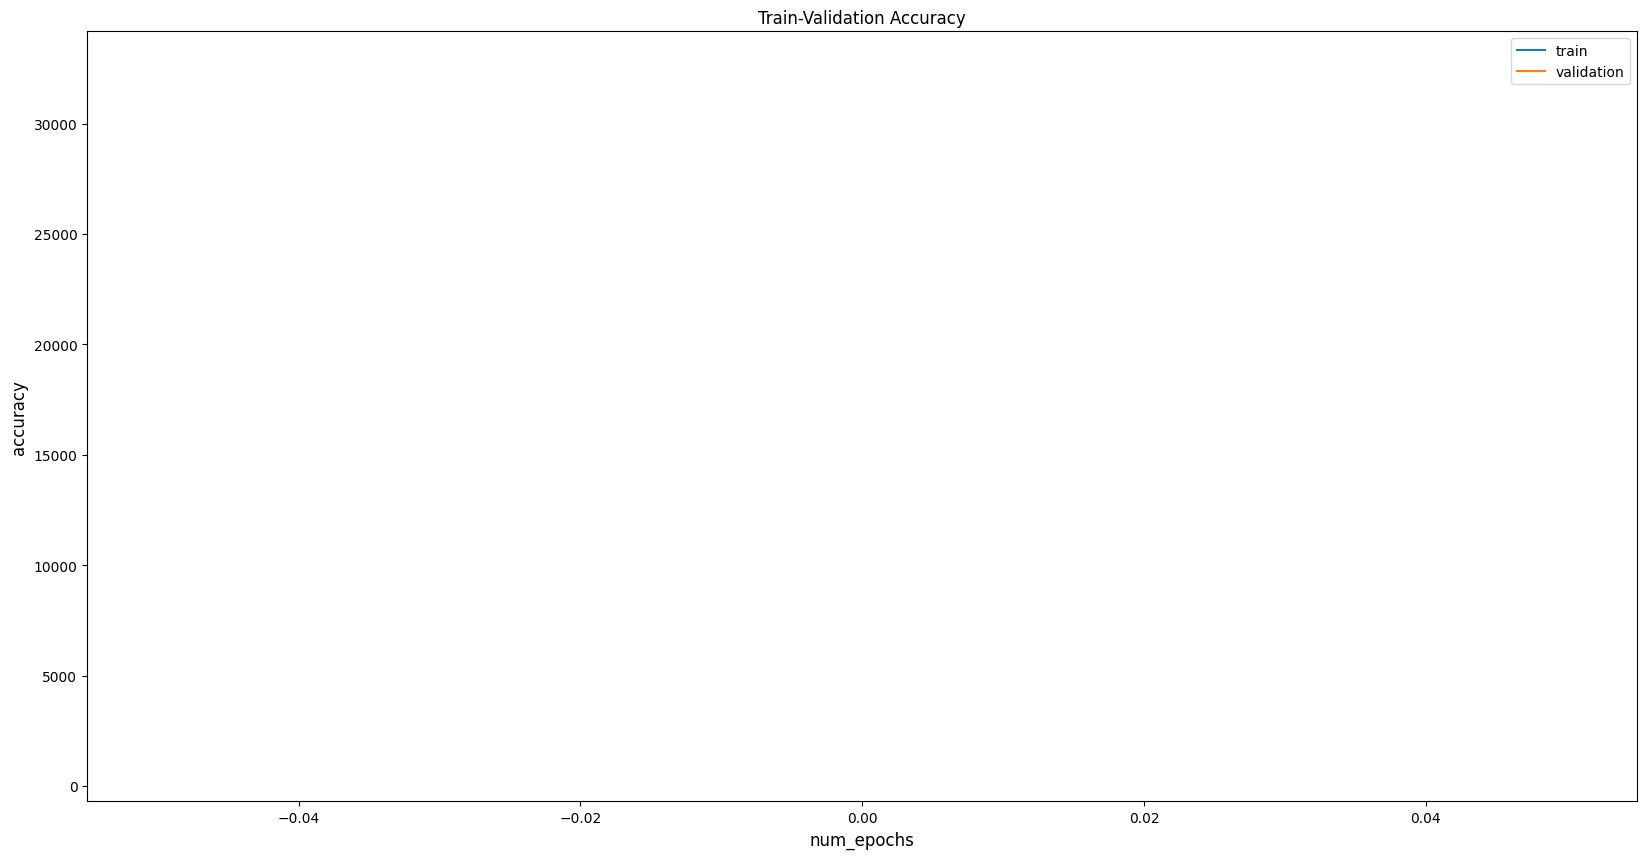

In [30]:
fig = plt.figure(figsize=(20,10))

plt.title("Train-Validation Accuracy")

plt.plot(train_acc, label='train')

plt.plot(valid_acc, label='validation')

plt.xlabel('num_epochs', fontsize=12)

plt.ylabel('accuracy', fontsize=12)

plt.legend(loc='best')

path of training data


In [5]:
train_data_path = 'datasets/traffic/archive/Test/'
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)


FileNotFoundError: Couldn't find any class folder in datasets/traffic/archive/Test/.

data loader for training and validation

In [ ]:
trainloader = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valloader = data.DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE)